# Presentación de la problemática

Una compañía de servicios (talefonía e internet) precisa analizar la base de datos de clientes, a partir de la cual se pretende modelar y predecir el Churn.

Los objetivos que pretendemos alcanzar son los siguientes:

    *Efectuar una limpieza del dataset provisto. Particularmente, deberán diseñar estrategias para lidiar con los datos perdidos en ciertas variables.
    *Realizar un análisis descriptivo de las principales variables.
    *Crear un dataset con el cual se pueda alimentar un modelo.
    *Estudiar diferentes modelos, análisis de features y desbalanceo de clases para encontrar la mejor predicción de churn en función de la métrica Recall. Esto último se debe a que la pregunta de negocio planteada es conocer la forma de retener la mayor cantidad de clientes posibles (reducir los falsos negativos), a expensas de molestar más clientes que igualmente continuarían con el servicio.
    *Lograr un deploy del modelo con una notebook de servidor y otra para que el cliente pueda operar de manera independiente
    


Info de las columnas

El dataset cuenta con las siguientes variables:

-customerID: Customer ID.

-gender: Whether the customer is a male or a female.

-SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)

-Partner: Whether the customer has a partner or not (Yes, No)

-Dependents: Whether the customer has dependents or not (Yes, No)

-tenure: Number of months the customer has stayed with the company

-PhoneService: Whether the customer has a phone service or not (Yes, No)

-MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service)

-InternetService: Customer’s internet service provider (DSL, Fiber optic, No)

-OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service)

-OnlineBackup: Whether the customer has online backup or not (Yes, No, No internet service)

-DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service)

-TechSupport: Whether the customer has tech support or not (Yes, No, No internet service)

-StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service)

-StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)

-Contract: The contract term of the customer (Month-to-month, One year, Two year)

-PaperlessBilling: Whether the customer has paperless billing or not (Yes, No)

-PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

-MonthlyCharges: The amount charged to the customer monthly

-TotalCharges: The total amount charged to the customer

-Churn: Whether the customer churned or not (Yes or No)


In [2]:
# Importamos todas las librerías que utilizaremos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_recall_curve, auc, ConfusionMatrixDisplay, PrecisionRecallDisplay, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from scikitplot.metrics import plot_roc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesRegressor
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV
import pickle
from sklearn.model_selection import KFold

In [4]:
# Importamos los datos y miramos los tipos de datos que tiene el dataset
location = "./WA_Fn-UseC_-Telco-Customer-Churn.csv"
pd.set_option("display.max_colwidth",200)
df = pd.read_csv(location,encoding = "utf-8")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# El dataset tiene datos continuos y discretos, separemoslos en dos listas.
continuas = ['tenure','monthlycharges','totalcharges']
discretas = ['gender', 'seniorcitizen', 'partner', 'dependents', 
       'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod',
         'churn']

In [6]:
# Defino una función para hacer una limpieza de datos y una estandarización de los nombres de las variables (todas minusculas)
def limpieza_df(data,features_continuas,features_discretas):
    customer_ID = []
    data.columns= data.columns.str.lower()
    for i in continuas:
        data.drop(data[data[i]==' '].index,inplace=True)
        data[i] = data[i].apply(lambda x: float(x))
    data
    customer_id = data.customerid
    data.drop(columns=['customerid'],axis=1,inplace=True)
    df_dummies = pd.get_dummies(data,drop_first=True)
    df_dummies.columns = df_dummies.columns.str.lower()
    return df_dummies,customer_id
# Esta función nos devolverá el dataset con las dummies y los datos
# de customer ID, que servirán para el deploy del modelo

In [7]:
# Ahora realizamos la limpieza. 
df_dummies = limpieza_df(df,continuas,discretas)

In [8]:
# Como la función de limpieza nos devuelve dos variables separadas, las juntamos en un nuevo df
customer_id = df_dummies[1]
df_dummies = df_dummies[0]
customer_id = pd.DataFrame(customer_id)
df_dummies = customer_id.join(df_dummies,how='left')

In [9]:
# Elimino features que no aportan información
df_dummies.drop(columns=['multiplelines_no phone service','onlinesecurity_no internet service','onlinebackup_no internet service','deviceprotection_no internet service','techsupport_no internet service','streamingtv_no internet service','streamingmovies_no internet service'],inplace=True)

In [10]:
# Vemos la cantidad de clientes que tienen diferentes tipos de servicios
# Los que tienen sólo teléfono son:
print('La cantidad de clientes que solo tienen internet son:')

print(len(df_dummies[(df_dummies['internetservice_no']==0) & (df_dummies['phoneservice_yes']==0)]))
print('-')
# Los que tienen sólo teléfono son:
print('La cantidad de clientes que solo tienen telefono:')
print(len(df_dummies[(df_dummies['internetservice_no']==1) & (df_dummies['phoneservice_yes']==1)]))
print('-')
# Los que tienen teléfono e internet:
print('La cantidad de clientes que tienen telefono e intenernet:')
print(len(df_dummies[(df_dummies['internetservice_no']==0) & (df_dummies['phoneservice_yes']==1)]))



La cantidad de clientes que solo tienen internet son:
680
-
La cantidad de clientes que solo tienen telefono:
1520
-
La cantidad de clientes que tienen telefono e intenernet:
4832


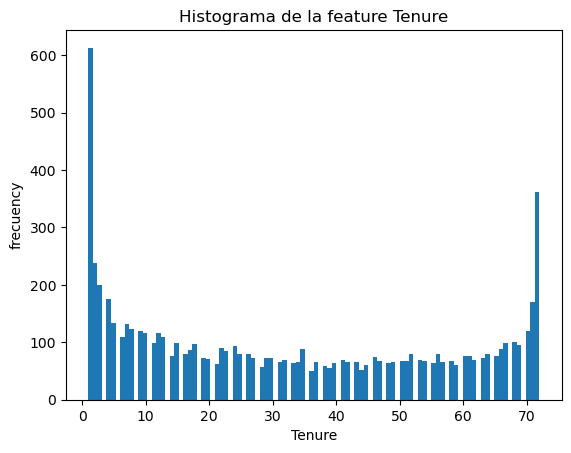

In [11]:
# Exploremos un poco los datos, en particular los referidos al Churn

x = df['tenure']
plt.hist(x, bins = 100)
plt.xlabel('Tenure')
plt.title('Histograma de la feature Tenure')
plt.ylabel('frecuency')
plt.show()

Vemos que hay un gran frecuencia de Tenure bajos, la cual disminuye conforma aumenta el tenure. Esto puede significar un churn alto para clientes con poco tiempo en la compañía. Por otro lado vemos que para churn altos hay una frecuencia mayor, esto puede significar clientes con mucha permanencia contratando el servicio. Este comportamiento puede cambiar con el tipo de cliente? Veamoslo..

In [12]:
df_dummies_int = df_dummies.loc[(df_dummies['internetservice_no']==0) & (df_dummies['phoneservice_yes']==0)]
df_dummies_tel = df_dummies.loc[(df_dummies['internetservice_no']==1) & (df_dummies['phoneservice_yes']==1)]
df_dummies_int_tel = df_dummies.loc[(df_dummies['internetservice_no']==0) & (df_dummies['phoneservice_yes']==1)]
df_dummies_internet1 = df_dummies.loc[(df_dummies['internetservice_no'] == 0)]

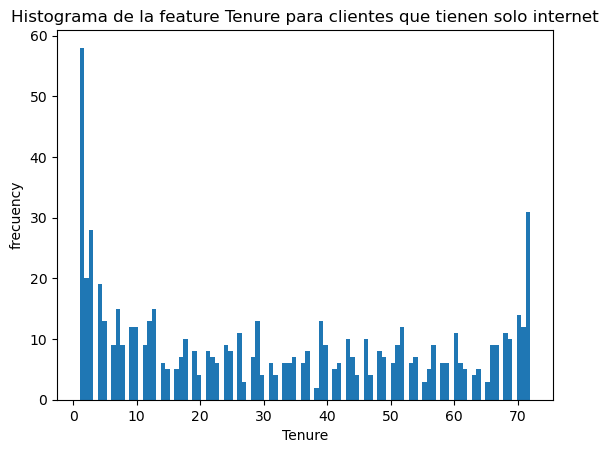

In [13]:
# Veamos como es la distribución del churn para cada caso
import matplotlib.pyplot as plt
x = df_dummies_int['tenure']
plt.hist(x, bins = 100,)
plt.xlabel('Tenure')
plt.title('Histograma de la feature Tenure para clientes que tienen solo internet')
plt.ylabel('frecuency')
plt.show()

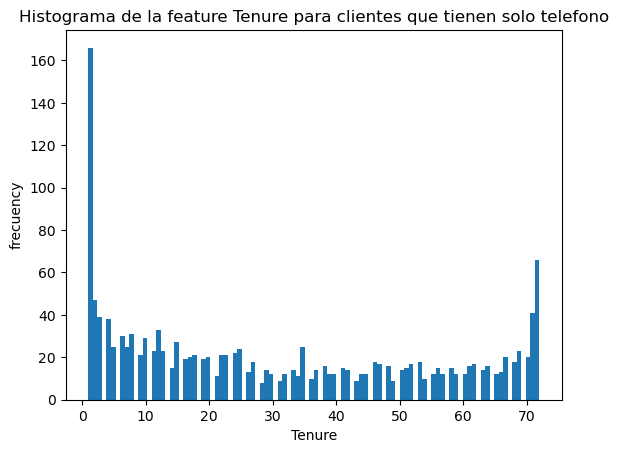

In [14]:
# Veamos como es la distribución del churn para cada casoç
x = df_dummies_tel['tenure']
plt.hist(x, bins = 100)
plt.xlabel('Tenure')
plt.title('Histograma de la feature Tenure para clientes que tienen solo telefono')
plt.ylabel('frecuency')
plt.show()

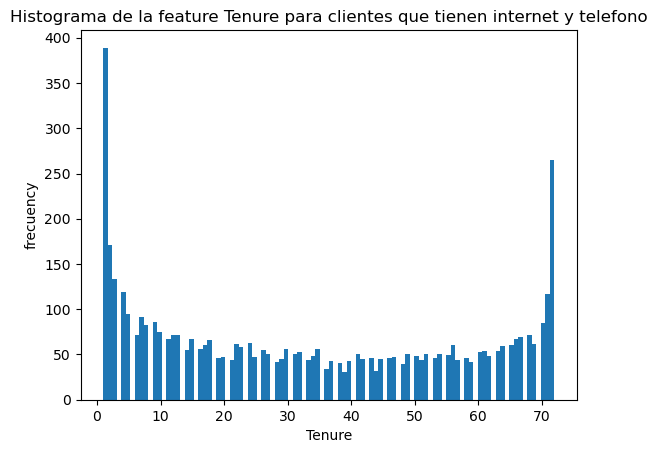

In [15]:
x = df_dummies_int_tel['tenure']
plt.hist(x, bins = 100)
plt.xlabel('Tenure')
plt.title('Histograma de la feature Tenure para clientes que tienen internet y telefono')
plt.ylabel('frecuency')
plt.show()


Vemos que el comportamiento es similar. Estudiemos entonces el porcentaje de churn para cada caso. 

In [16]:
print('porcentaje de churn en clientes que solo tienen internet: ',(df_dummies_int.churn_yes.sum()/len(df_dummies_int))*100,'%')
print('porcentaje de churn en clientes que solo tienen telefono: ',round((df_dummies_tel.churn_yes.sum()/len(df_dummies_tel))*100,2),'%')
print('porcentaje de churn en clientes que tienen telefono e internet: ',round((df_dummies_int_tel.churn_yes.sum()/len(df_dummies_int_tel))*100,2),'%')


porcentaje de churn en clientes que solo tienen internet:  25.0 %
porcentaje de churn en clientes que solo tienen telefono:  7.43 %
porcentaje de churn en clientes que tienen telefono e internet:  32.82 %


Vemos que el porcentaje de churn para los clientes que sólo tienen el servicio de clientes es muy bajo con respecto al resto, por lo que nos enfocaremos en los clientes con INTERNET + TELEFONO

Estudiemos la relación entre variables

In [17]:
fig = px.scatter(x=df[df['internetservice']!='No'].tenure, y=df[df['internetservice']!='No'].totalcharges, 
                 color = df[df['internetservice']!='No'].churn, template = 'presentation', 
                 opacity = 0.5, facet_col = df[df['internetservice']!='No'].contract, 
                 title = 'Customer Churn by Tenure, Charges, and Contract Type',
                 labels = {'x' : 'Customer Tenure', 'y' : 'Total Charges $'})
              
fig.show()

Podemos observar que quienes contrataron un servicio mensual acumulan mayor churn para tenure bajos, en cambio quienes tienen un servicio más largo (anual o bi anual) poseen un churn mucho más bajo. Esto sumado a los histogramas muestran que hay un porcentaje de clientes que están muy poco tiempo contratando el servicio.

In [18]:
# Exploremos algunas otras variables

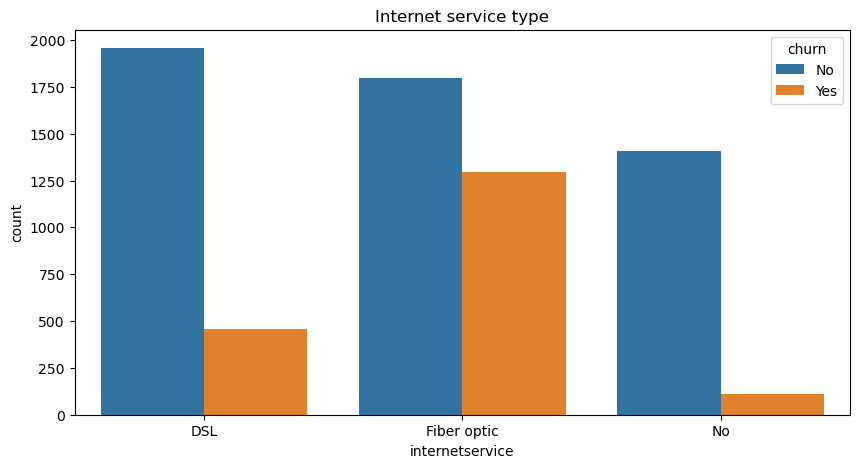

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(x='internetservice', hue='churn', data=df)
plt.title('Internet service type')
plt.show()


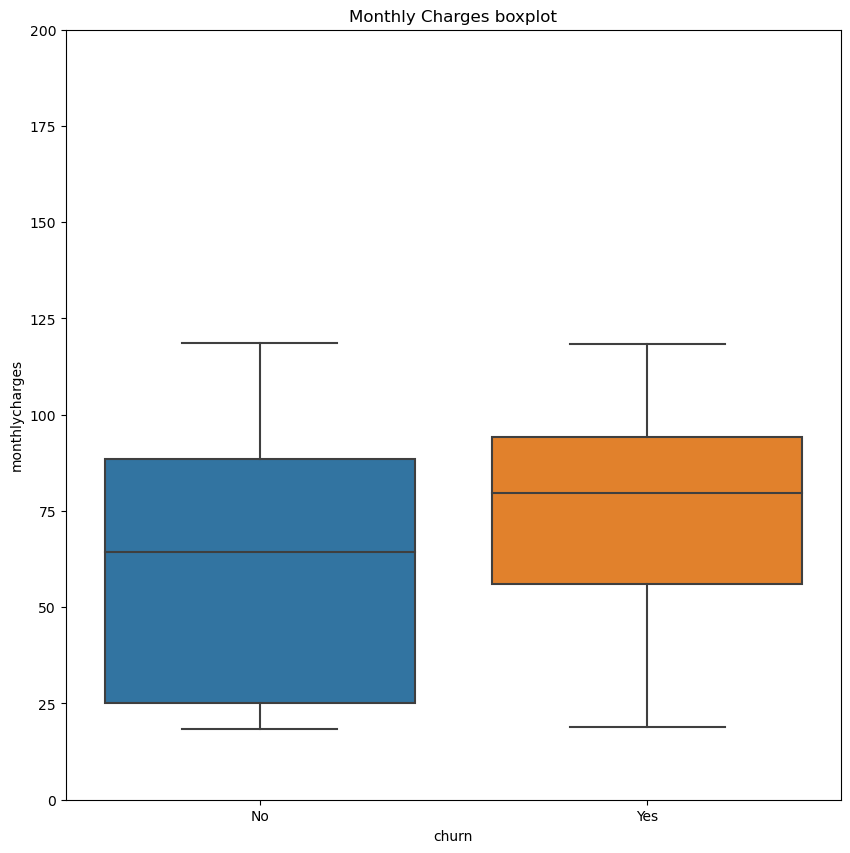

In [20]:
plt.figure(figsize=(10,10))
plt.ylim(0,200)
sns.boxplot(x='churn', y='monthlycharges',data=df)
plt.title('Monthly Charges boxplot')
plt.show()


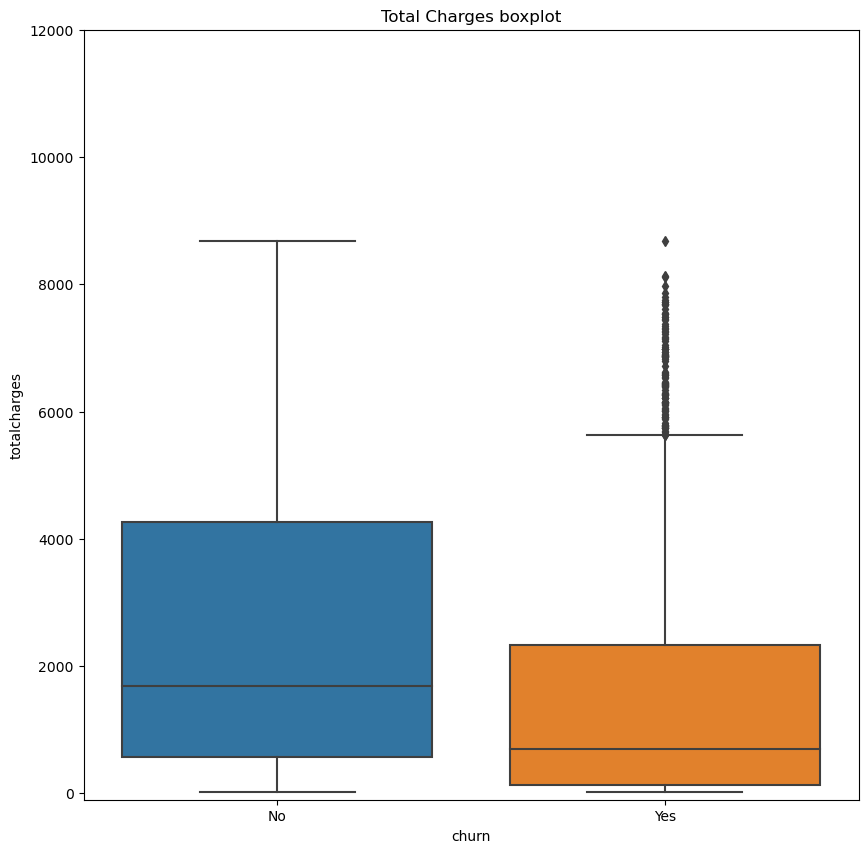

In [21]:
plt.figure(figsize=(10,10))
plt.ylim(-100,12000)
sns.boxplot(x='churn', y='totalcharges',data=df)
plt.title('Total Charges boxplot')
plt.show()

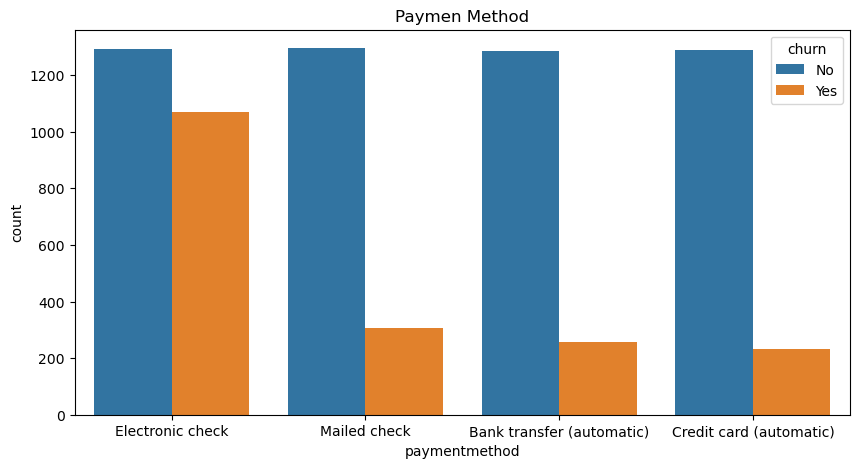

In [22]:
plt.figure(figsize=(10,5))
sns.countplot(x='paymentmethod', hue='churn', data=df)
plt.title('Paymen Method')
plt.show()

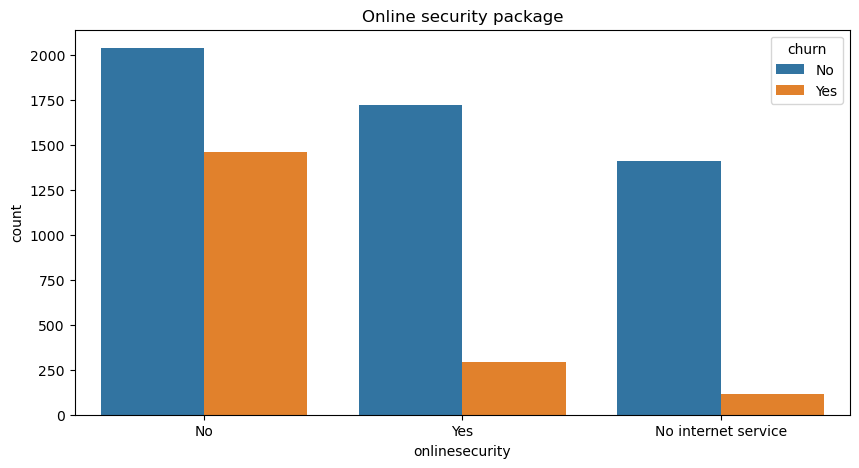

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(x='onlinesecurity', hue='churn', data=df)
plt.title('Online security package')
plt.show()

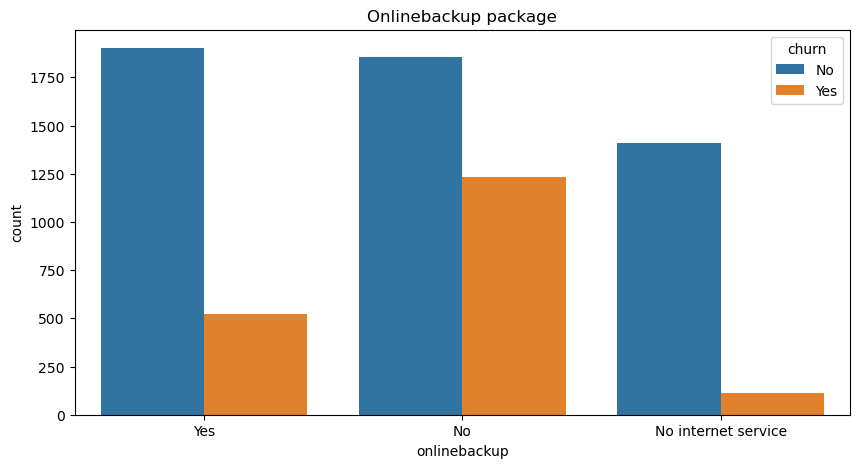

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(x='onlinebackup', hue='churn', data=df)
plt.title('Onlinebackup package')
plt.show()

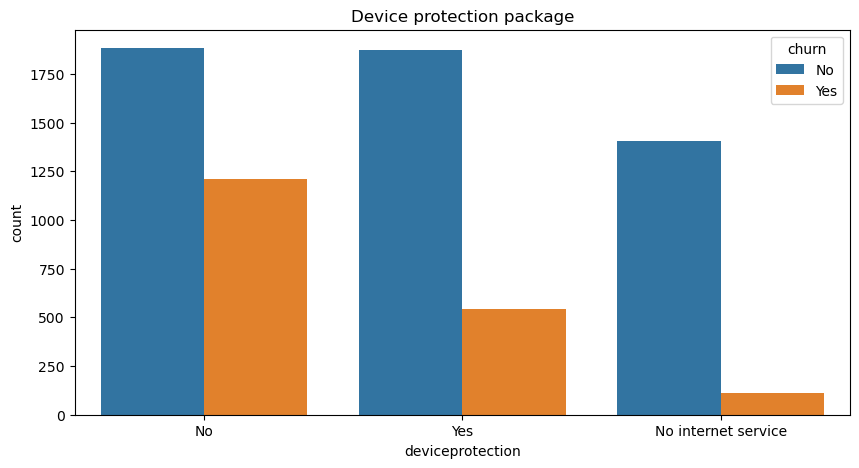

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(x='deviceprotection', hue='churn', data=df)
plt.title('Device protection package')
plt.show()

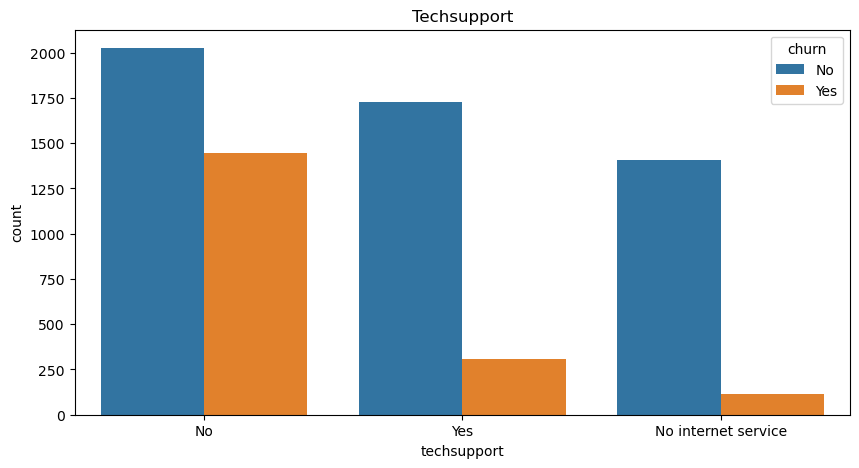

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(x='techsupport', hue='churn', data=df)
plt.title('Techsupport')
plt.show()

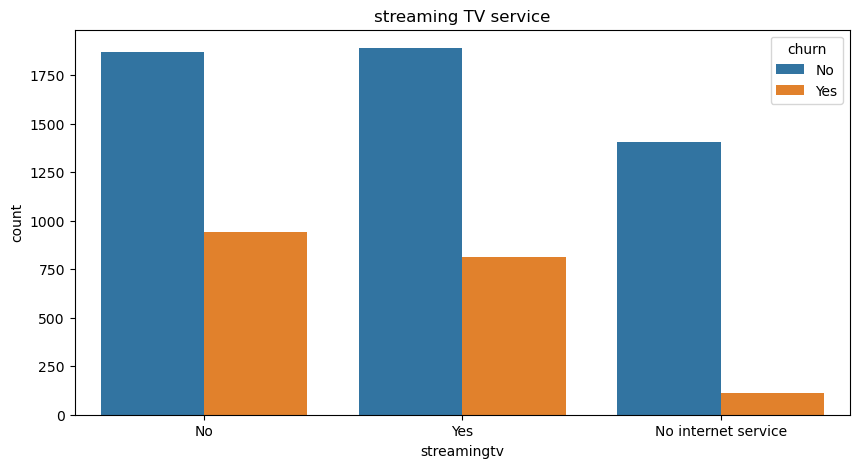

In [27]:
plt.figure(figsize=(10,5))
sns.countplot(x='streamingtv', hue='churn', data=df)
plt.title('streaming TV service')
plt.show()

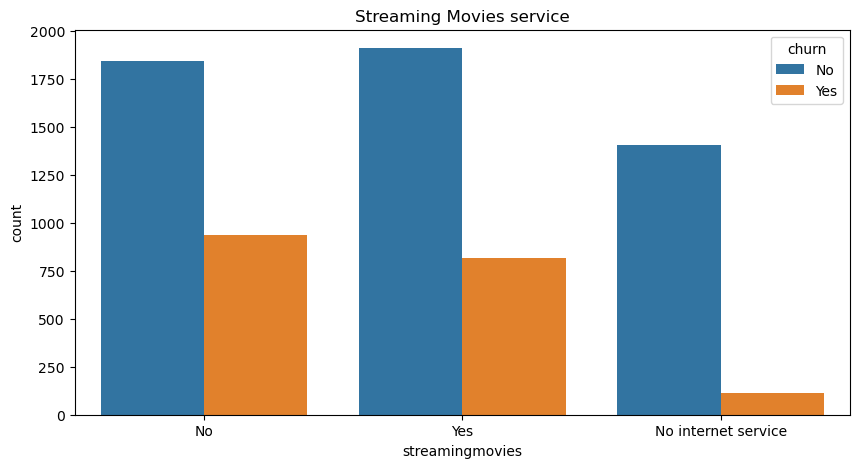

In [28]:
plt.figure(figsize=(10,5))
sns.countplot(x='streamingmovies', hue='churn', data=df)
plt.title('Streaming Movies service')
plt.show()

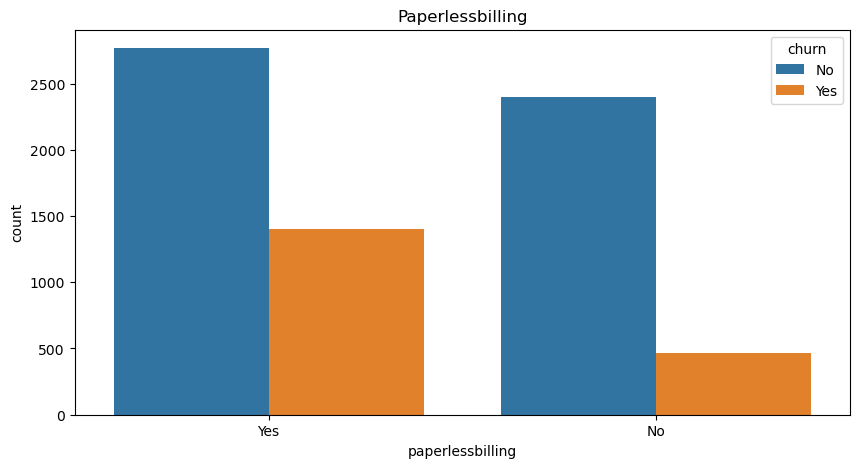

In [29]:

plt.figure(figsize=(10,5))
sns.countplot(x='paperlessbilling', hue='churn', data=df)
plt.title('Paperlessbilling')
plt.show()

In [30]:
# Ahora comenzamos con la evaluación de los modelos

In [60]:
# Defino una funición para evaluar el modelo
def evaluar_modelo(modelo,X_test,y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)
    print(classification_report(y_test,y_pred))
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
    precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);
    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))
    conf_mat_ensemble = confusion_matrix(y_test, y_pred)
    print(conf_mat_ensemble)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_ensemble)
    disp.plot()
    plt.show()
    
    plot_roc(y_test, modelo.predict_proba(X_test), plot_micro = False, plot_macro= False);

    return

In [61]:
# Separo en features y variable objetivo, separo en test y train (con un stratify = y para no tener desbalance de la var objetivo)
# Genero un CV que luego utilizaré
X = df_dummies_internet1.drop(columns=['customerid','churn_yes'])
y = df_dummies_internet1.churn_yes
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=255)
cv = StratifiedKFold(n_splits=5, random_state=983, shuffle=True)

In [62]:
#Instancio métodos para trabajar con clases desbalanceadas y algunos clasificadores.
smote=SMOTENC(categorical_features=[0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],sampling_strategy='minority',random_state=123);
oversampler=RandomOverSampler(sampling_strategy='minority',random_state=123); # iguala las clases
undersampler=RandomUnderSampler(sampling_strategy='majority',random_state=123); # iguala las clases
xgb_clasificador = xgb.XGBClassifier()
dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2, random_state = 11)

In [63]:
# Creo una clase para poder utilizar los estimadores en un gridsearch
class ClassifierWrapper(BaseEstimator):
    """
    A Custom Wrapper that can switch between classifiers.
    """ 
    def __init__(self, estimator=None):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

Para correr el modelo por primera vez hay que descomentar la siguiente celda. Sino en la que sigue lo traemos ya entrenado.

In [64]:

# # Ahora con un pipeline y un gridsearch exploramos la mejor combinación de hiperparámetros para la variable objetivo 'recall

# # Hago un grid search en un pipeline completo

# pipe_full = Pipeline([('feature_selection',SelectKBest(chi2, k = 10)),
#     ('feature_engineering',SelectKBest(chi2, k = 10)),
#          ('preprocesamiento', StandardScaler()),
#     ('switchable', ClassifierWrapper())])


# hyperparameters = [
   
#         {
#         # CLasificador Logistic regresion
#         'feature_selection': [SelectKBest(chi2,k=10),None],
#         'feature_engineering':[SelectKBest(chi2, k = 10),smote,oversampler,undersampler, None],
#         'preprocesamiento':[StandardScaler(), MinMaxScaler(),None],
#         'switchable__estimator': [GaussianNB()],
#         'switchable__estimator__var_smoothing': np.logspace(0,-9, num=100),
#     },
#     {
#         # CLasificador Logistic regresion
#         'feature_selection': [SelectKBest(chi2,k=10),None],
#         'feature_engineering':[SelectKBest(chi2, k = 10),smote,oversampler,undersampler, None],
#         'preprocesamiento':[StandardScaler(), MinMaxScaler(),None],
#         'switchable__estimator': [LogisticRegression()],
#         'switchable__estimator__C': [1, 10, 100, 1000],
#         'switchable__estimator__penalty': ['l1', 'l2',],
#         'switchable__estimator__solver': ['saga'],
#     },
#     {
#         # GradientBoostClassifier
#         'feature_selection': [SelectKBest(chi2,k=10),None],
#         'feature_engineering':[SelectKBest(chi2, k = 10),smote,oversampler,undersampler, None],
#         'preprocesamiento':[StandardScaler(), MinMaxScaler(),None],
#         'switchable__estimator': [GradientBoostingClassifier()],
#         'switchable__estimator__n_estimators':[5,50,250,500],
#         'switchable__estimator__max_depth':[1,3,5,7,9],
#         'switchable__estimator__learning_rate':[0.01,0.1,0.2,0.3,0.4,0.5]
#     },
#     {
#         # RandomforestClassifier
#         'feature_selection': [SelectKBest(chi2,k=10),None],
#         'feature_engineering':[SelectKBest(chi2, k = 10),smote,oversampler,undersampler, None],
#         'preprocesamiento':[StandardScaler(), MinMaxScaler(),None],
#         'switchable__estimator': [RandomForestClassifier(random_state = 5)],
#         'switchable__estimator__n_estimators': [1,100,200, 500,1000],
#         'switchable__estimator__max_features': ['auto', 'sqrt', 'log2'],
#         'switchable__estimator__max_depth' : [4,5,6,7,8,9,10,11,12],
#         'switchable__estimator__criterion' :['gini', 'entropy']
#     },
#     {
#         # XGBoost Classifier
#         'feature_selection': [SelectKBest(chi2,k=10),None],
#         'feature_engineering':[SelectKBest(chi2, k = 10),smote,oversampler,undersampler, None],
#         'preprocesamiento':[StandardScaler(), MinMaxScaler(),None],
#         'switchable__estimator': [xgb_clasificador],
#         "switchable__estimator__n_estimators": [50,100,500,1000],      
#         "switchable__estimator__max_depth": [1,2,3,4,5],           
#         "switchable__estimator__learning_rate": [0.01, 0.1,0.2,0.3,0.4]   
    
#     },

# # ]


# # grid_pipe_recall = GridSearchCV(pipe_full, hyperparameters, cv=cv, scoring='recall',verbose=1,n_jobs=-1)

# # grid_pipe_recall.fit(X_train, y_train);

# # # Guardo el mejor modelo

# # model = grid_pipe_recall.best_estimator_
# # nombre_modelo = 'best_pipe_grid_recall'
# # dir_='.'+'/'+nombre_modelo+'.pkl'
# # with open(dir_, 'wb') as modelo_pkl:
# #         pickle.dump(model, modelo_pkl)

In [65]:
# dir_='.'+'/'
with open('./best_pipe_grid_recall.pkl', 'rb') as modelo_pkl:
        model = pickle.load(modelo_pkl)

              precision    recall  f1-score   support

           0       0.89      0.55      0.68       939
           1       0.47      0.86      0.61       439

    accuracy                           0.65      1378
   macro avg       0.68      0.70      0.64      1378
weighted avg       0.76      0.65      0.66      1378

Area bajo la curva ROC: 0.7866
Area bajo la curva Precision-Recall: 0.6052
[[518 421]
 [ 63 376]]


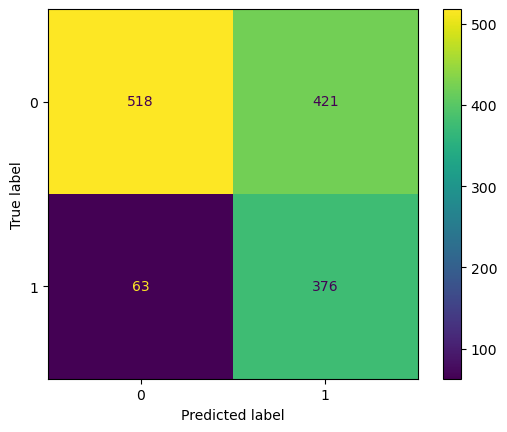

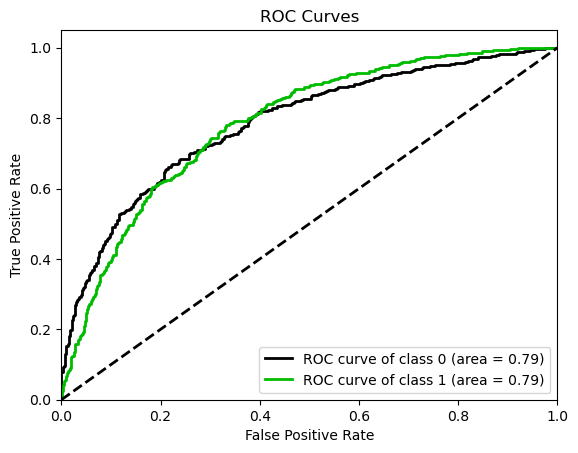

In [66]:
#Evaluo el mejor pipe
evaluar_modelo(model,X_test,y_test)

In [67]:
model

Pipeline(steps=[('feature_selection', None),
                ('feature_engineering',
                 RandomOverSampler(random_state=123,
                                   sampling_strategy='minority')),
                ('preprocesamiento', MinMaxScaler()),
                ('switchable',
                 ClassifierWrapper(estimator=GaussianNB(var_smoothing=1.0)))])

In [68]:
# Tratamos de estudiar el modelo y las features con la librería shap
import shap

In [69]:
explainer = shap.Explainer(model.predict,X)
shap_values = explainer(X)

Permutation explainer: 5513it [01:26, 56.34it/s]                          


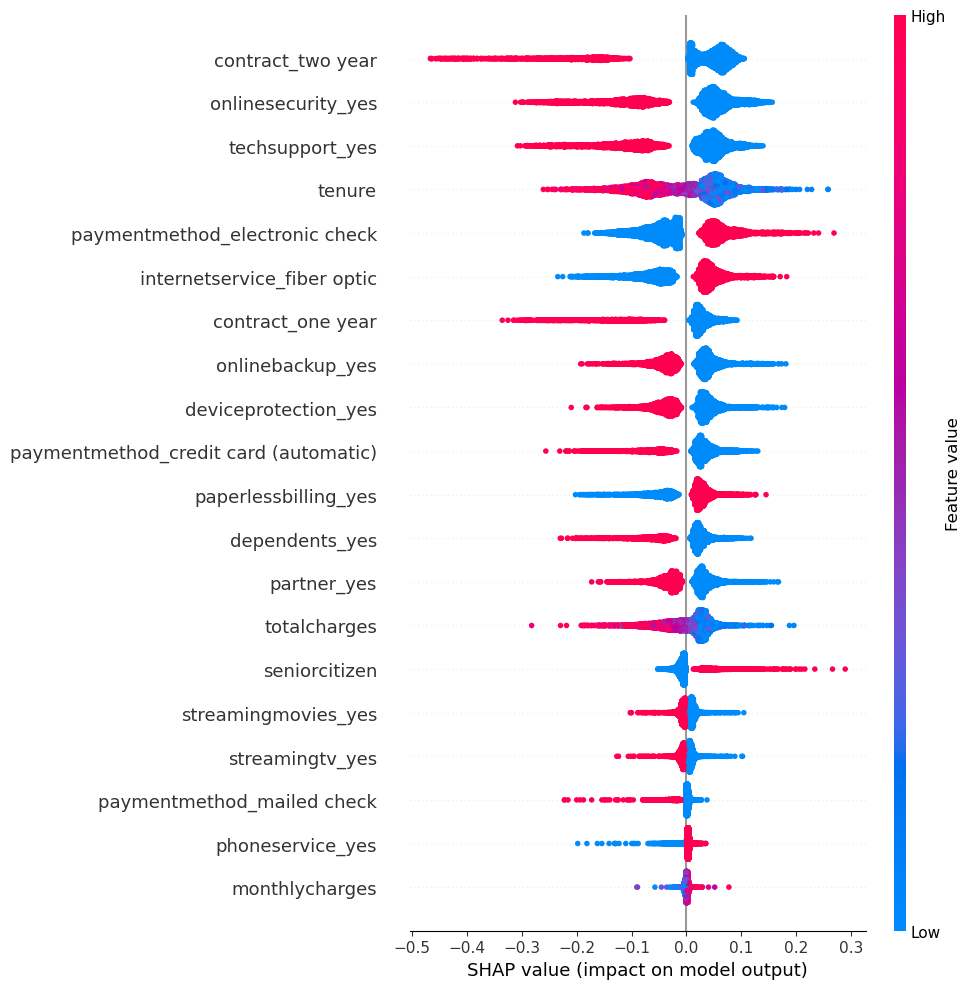

In [70]:
shap.summary_plot(shap_values, X,plot_size=(10,10))

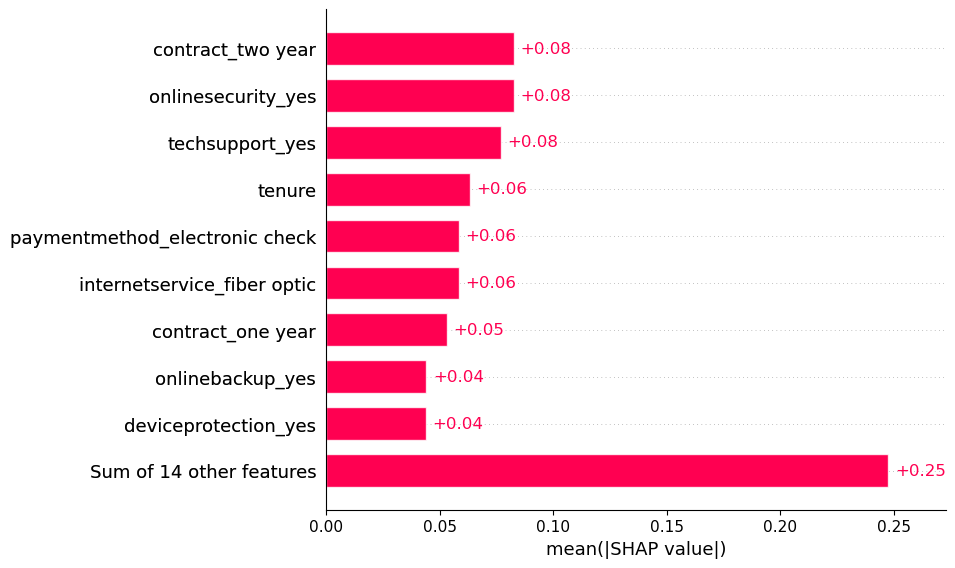

In [71]:
shap.plots.bar(shap_values)



`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
No/low signal found from feature 4 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 8 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 10 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


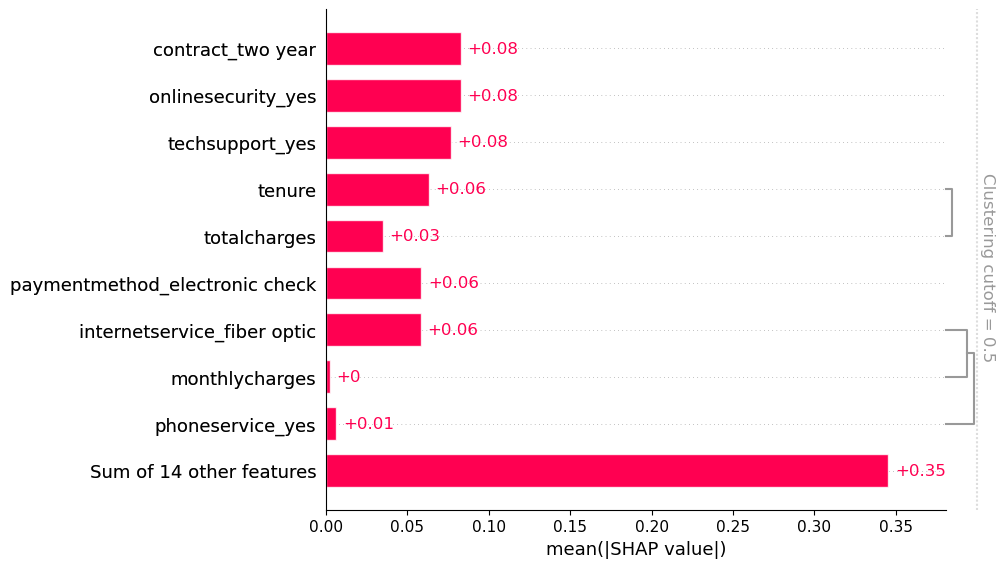

In [72]:
# También podemos hacer gráficos de clustering para ver que variables están relacionadas
clustering = shap.utils.hclust(X, y) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
shap.plots.bar(shap_values, clustering=clustering)